# Fashion MNIST Dataset

In [30]:
# Install library
%pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [48]:
# Import libraries

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from sklearn.decomposition import PCA

# Import libraries

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

## Data Exploration and Processing

In [32]:
#  Define transform to normalize data

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [33]:
# Download training data

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Users/lorraynereis/.pytorch/F_MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [34]:
# Load trainset

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

trainloader

In [35]:
# Download test data

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /Users/lorraynereis/.pytorch/F_MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [36]:
# Load testset

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

testloader

In [37]:
# Check shape of images and labels

images, labels = next(iter(trainloader))

print("Images shape:",images.shape)
print("Labels shape:",labels.shape)

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


Image shape: torch.Size([1, 28, 28])
Label: 9


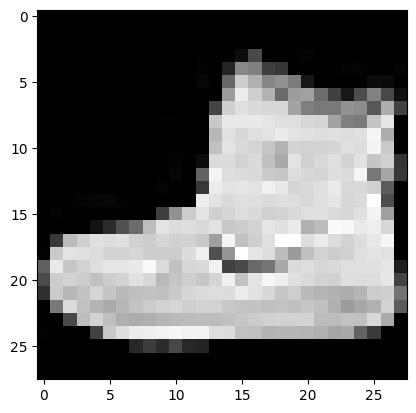

In [38]:
# Vizualize batch of training data 

image,label = trainset[0]

print("Image shape:",image.shape)
print("Label:",label)

plt.imshow(image.reshape(28,28),cmap="gray")

In [39]:
# Get classes 

classes = trainset.classes

print(classes)


['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [40]:
# Print target values 

target_values = trainset.targets

print(target_values.unique())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


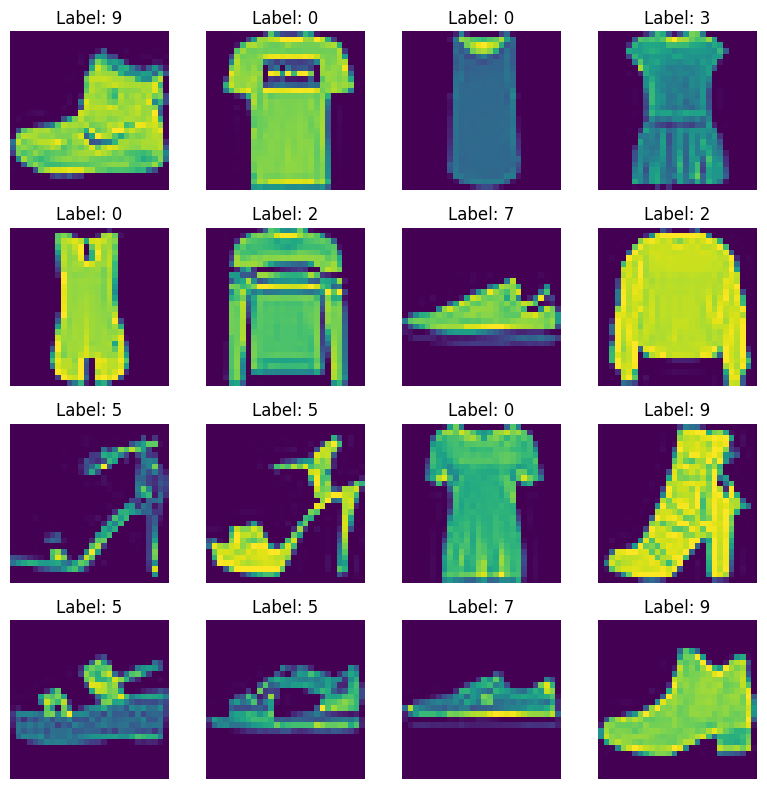

In [41]:
# Vizualize images 

figure, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot
for x in range(4):
    for j in range(4):
        image, label = trainset[x * 4 + j]  # Get image and label
        image_numpy = image.numpy().squeeze()
        axs[x, j].imshow(image_numpy)  # Plot the image
        axs[x, j].axis('off')
        axs[x, j].set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

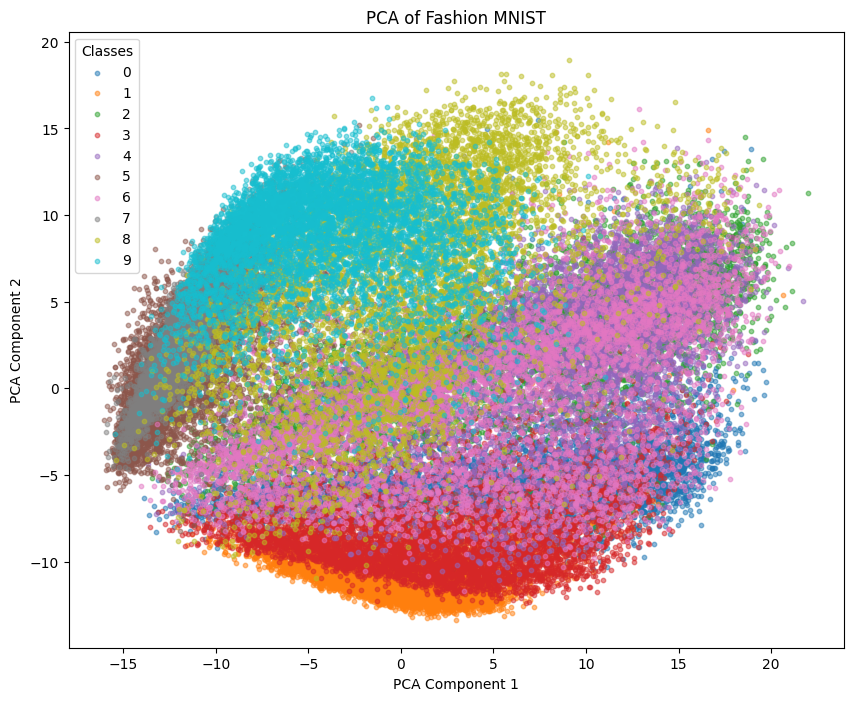

In [42]:
 # Dimensional Reduction Visualization 


images = []
labels = []

for i in range(len(trainset)):
    image, label = trainset[i]
    images.append(image.view(-1))  # Flatten the 28x28 image to a 784-dimensional vector
    labels.append(label)

# Convert images and labels to numpy arrays for PCA
images = np.array(images)
labels = np.array(labels)

# Apply PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(images)

# Plot the results
plt.figure(figsize=(10, 8))

# Use different colors for each class (digit)
for digit in range(10):
    indices = np.where(labels == digit)
    plt.scatter(reduced_data[indices, 0], reduced_data[indices, 1], label=str(digit), alpha=0.5, s=10)

plt.title("PCA of Fashion MNIST")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Classes")
plt.show()


### Model Implementation

In [43]:
class BaseCNN(nn.Module):
#  Based in :  https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [44]:
# Print model

model= BaseCNN()
print(model)

BaseCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [45]:
# Define a function to calculate the accuracy of the model
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, 1) # Get the predicted classes from the output logits

  return torch.sum(preds == labels).item() / len(labels) # Return the ratio of correct predictions

In [46]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, labels in train_loader:
            images = images.to(device)  
            labels = labels.to(device)

            # Zero gradients, forward pass, loss, backward pass, optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update loss and accuracy
            running_loss += loss.item() * images.size(0)
            running_acc += accuracy(outputs, labels) * images.size(0)

        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_acc / len(train_loader.dataset)

        # Print results for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [49]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_model(model, trainloader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 1.1925, Accuracy: 0.5739
Epoch [2/10], Loss: 0.6771, Accuracy: 0.7421
Epoch [3/10], Loss: 0.5848, Accuracy: 0.7762
Epoch [4/10], Loss: 0.5240, Accuracy: 0.8005
Epoch [5/10], Loss: 0.4789, Accuracy: 0.8208
Epoch [6/10], Loss: 0.4457, Accuracy: 0.8337
Epoch [7/10], Loss: 0.4189, Accuracy: 0.8451
Epoch [8/10], Loss: 0.3974, Accuracy: 0.8528
Epoch [9/10], Loss: 0.3810, Accuracy: 0.8588
Epoch [10/10], Loss: 0.3670, Accuracy: 0.8647


In [50]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    print(f'Test Loss: {test_loss / len(test_loader.dataset):.4f}, Accuracy: {correct / len(test_loader.dataset):.4f}')

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model,device, testloader, criterion)

Test Loss: 0.0062, Accuracy: 0.8513


In [52]:
# Implement CNN improvement

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)  # Batch normalization for the first convolution
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)  # Batch normalization for the second convolution
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x